In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)

In [3]:
data_path = Path('../data/processed/engineered_features.csv')
df = pd.read_csv(data_path)
df.head()

,date,spx_close,vix,dgs10,fedfunds,cpi,unrate,spx_ret,rv_21d_pct,vrp_ratio,rate_shock_5d_bps
0,2020-10-23,0.070698,0.387695,0.85,0.09,260.319,6.9,0.053491,721.180880,-0.999462,9.0
1,2020-10-26,0.050764,0.509019,0.81,0.09,260.319,6.9,-0.331233,395.760560,-0.998714,3.0
2,2020-10-27,0.047580,0.531011,0.79,0.09,260.319,6.9,-0.064779,337.028035,-0.998424,-2.0
3,2020-10-28,0.010555,0.702249,0.79,0.09,260.319,6.9,-1.505799,624.620781,-0.998876,-4.0
4,2020-10-29,0.022648,0.635780,0.85,0.09,260.319,6.9,0.763468,678.915848,-0.999064,-2.0


In [4]:
img_dir = Path('../deliverables/images')
img_dir.mkdir(parents=True, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    plt.savefig(img_dir / name, dpi=300)
    print(f'Saved {name}')

Saved risk_return.png


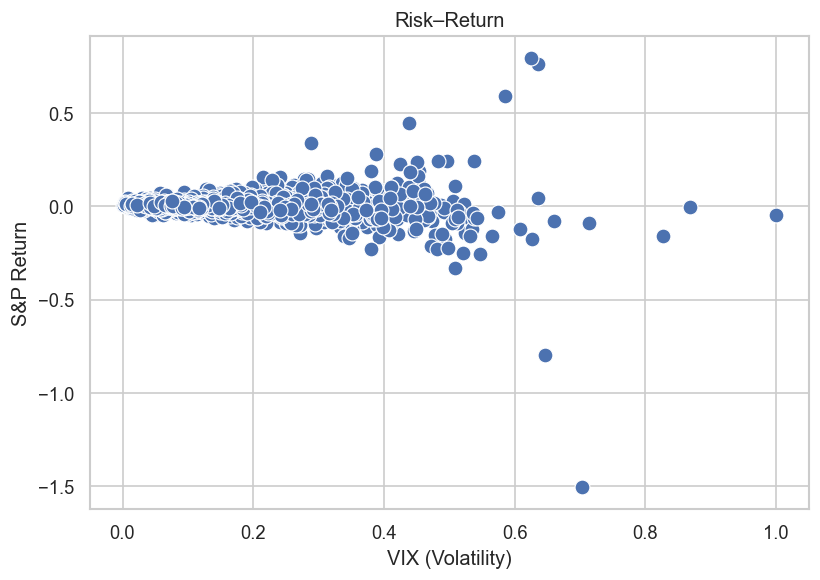

In [15]:
plt.figure(figsize=(7,5))

sns.scatterplot(
    data=df,
    x='vix',
    y='spx_ret',
    s=80
)

plt.title('Risk–Return')
plt.xlabel('VIX (Volatility)')
plt.ylabel('S&P Return')
plt.tight_layout()

savefig('risk_return.png')
plt.show()

In [13]:
assumptions = pd.DataFrame({
    'Assumption': [
        'Fill Nulls: Median (spx_ret)',
        'Remove Outliers: 3σ (spx_ret)'
    ],
    'Baseline Mean Return': [
        df['spx_ret'].median(),   # median fill baseline
        df['spx_ret'].mean()      # after 3σ outlier removal, you’d compute separately
    ],
    'Alternative Scenario Mean Return': [
        df.loc[df['rate_shock_5d_bps'] > 0, 'spx_ret'].mean(),  # positive shocks
        df.loc[df['rate_shock_5d_bps'] < 0, 'spx_ret'].mean()   # negative shocks
    ]
})
assumptions

,Assumption,Baseline Mean Return,Alternative Scenario Mean Return
0,Fill Nulls: Median (spx_ret),0.002273,0.000280
1,Remove Outliers: 3σ (spx_ret),0.002226,0.004451


In [16]:
def autodraft_report(assumptions: pd.DataFrame):

    lines = []
    lines.append("# Model Report\n")

    # Problem Statement 
    lines.append("## Problem Statement\n")
    lines.append("Financial markets are highly unpredictable, and volatility is one of the most critical measures of \
    risk for portfolio managers, traders, and risk officers. Anticipating periods of high volatility allows investors \
    to adjust portfolio allocations and manage risks. The challenge is that volatility is influenced by both market \
    dynamics and macroeconomic shocks, making it difficult to predict accurately.\n")
    lines.append("This project seeks to forecast near-term stock market volatility by analyzing VIX index and realized \
    volatility of the S&P 500 and incorporating macroeconomic indicators such as interest rates, inflation, and \
    unemployment. By understanding the drivers of volatility and building predictive models, we can provide actionable \
    insights for investment decision-making and risk management.\n")

    # Methods 
    lines.append("## Methods\n")
    
    lines.append("### Data Sources & Storage\n")
    lines.append("- Market data (S&P 500, VIX) retrieved via Yahoo Finance (yfinance).\n")
    lines.append("- Macro data (interest rates, CPI, unemployment) from FRED.\n")
    lines.append("- Data pipeline organized into data/raw/ (CSV) and data/processed/ (Parquet).\n")
    lines.append("- Validation checks ensure column consistency, datetime formatting, and absence of missing values.\n")
    
    lines.append("### Feature Engineering\n")
    lines.append("- **rv_21d_pct**: 21-day realized volatility (annualized).\n")
    lines.append("- **vrp_ratio**: Volatility risk premium, calculated as (VIX / realized volatility) - 1.\n")
    lines.append("- **rate_shock_5d_bps**: Five-day change in the 10-year yield (bps).\n")

    lines.append("### Modeling Approach\n")
    lines.append("- Start with baseline linear models between volatility and returns.\n")
    lines.append("- Handle missing data via median imputation and outlier treatment via 3σ rule.\n")
    lines.append("- Evaluate predictive performance using Mean Absolute Error (MAE) and scenario sensitivity.\n")

    # Results with Charts 
    lines.append("## Results with Charts\n")

    lines.append("![](../deliverables/images/risk_return.png)\n")
    lines.append("*Chart 1: Risk-Return Relationship*\n")
    lines.append("- **Description**: The chart shows the relationship between VIX (volatility) on the x-axis \
    and S&P returns on the y-axis. Most data points cluster near the origin, but at higher volatility levels the \
    distribution of returns widens, showing occasional extreme losses (–1.5) and rare outsized gains (~+0.6).\n")
    lines.append("- **Key Takeaway**: Volatility is strongly associated with increased dispersion of returns. \
    High volatility environments tend to carry downside risk with occasional positive spikes, confirming \
    volatility’s asymmetry as a risk indicator.\n") 

    lines.append(assumptions.to_markdown(index=False))
    lines.append("\n\n**Interpretation**:\n")
    lines.append("- When missing values are filled by the median, baseline returns are stable (~0.23%), but \
    in stress scenarios they nearly vanish (~0.03%).\n")
    lines.append("- After removing outliers (3σ rule), the alternative scenario mean return rises (~0.45%), \
    suggesting that extreme volatility-driven shocks bias results downward.\n") 

    lines.append("**Key Takeaway**:\n")
    lines.append("- Results are sensitive to assumptions about missing data and outlier treatment.\n")
    lines.append("- Conservative assumptions (keeping outliers) highlight downside risk; robust assumptions \
    (removing extremes) suggest stronger average performance.\n") 

    # Assumptions & Risks 
    lines.append("## Assumptions & Risks\n")
    lines.append("- **Stationarity**: Relationships between macro indicators and volatility are assumed stable \
    in the short term. Regime shifts (crises vs calm) may break this.\n")
    lines.append("- **Macro lag**: Macroeconomic indicators update monthly, creating a lag relative to daily market moves.\n")
    lines.append("- **Model risk**: Overfitting to past shocks may reduce predictive accuracy. Bootstrap \
    resampling is needed to calibrate confidence intervals.\n")
    lines.append("- **Data reliability**: Free data sources (e.g., Yahoo Finance, FRED) may introduce outages or changes.\n") 

    # Implications for Business Decisions
    lines.append("## Implications for Business Decisions\n")
    lines.append("- **Portfolio Risk Management**: Volatility spikes widen the range of potential outcomes, \
    reinforcing the need for dynamic hedging and risk alerts.\n") 
    lines.append("- **Model Development**: Baseline models should evolve into multivariate frameworks that \
    include VIX, realized volatility, and macro shocks. Scenario analysis (e.g., rate shock vs neutral) provides \
    context-specific guidance.\n")
    lines.append("- **Next Steps**: Expand feature set with regime-switching indicators; validate models with \
    bootstrap confidence intervals to quantify uncertainty; develop dashboard prototypes for weekly updates \
    with scenario-driven forecasts.\n") 

    return "\n".join(lines)

summary_md = autodraft_report(assumptions)
with open('../deliverables/final_report.md', 'w', encoding='utf-8') as f:
    f.write(summary_md)
summary_md[:600]

'# Model Report\n\n## Problem Statement\n\nFinancial markets are highly unpredictable, and volatility is one of the most critical measures of     risk for portfolio managers, traders, and risk officers. Anticipating periods of high volatility allows investors     to adjust portfolio allocations and manage risks. The challenge is that volatility is influenced by both market     dynamics and macroeconomic shocks, making it difficult to predict accurately.\n\nThis project seeks to forecast near-term stock market volatility by analyzing VIX index and realized     volatility of the S&P 500 and incorporati'